# PyTorch Quickstart

[Link to the related offical tutorial](https://docs.pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html). Based by Update: Jan 24, 2025

We’ll use the FashionMNIST dataset to train a neural network that predicts if an input image belongs to one of the following classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, or Ankle boot.

Vision Datasets: https://docs.pytorch.org/vision/stable/datasets.html

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:05<00:00, 5.09MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 87.8kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 1.64MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.3MB/s]


In [ ]:
print("Sizes: ", len(training_data), len(test_data))
print("Inside: ", len(training_data[0]), len(training_data[0][0]), len(training_data[0][0][0]))
print("Atom: ", type(training_data[0][0][0]),training_data[0][0][0].size())

Sizes:  60000 10000
Inside:  2 1 28
Atom:  <class 'torch.Tensor'> torch.Size([28, 28])


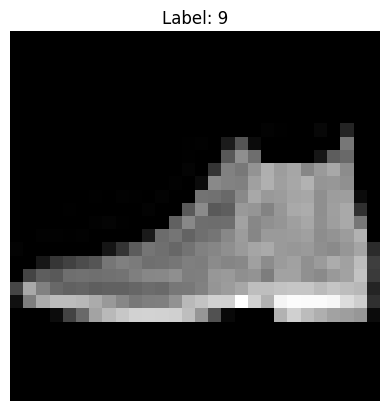

Method - using PIL Image directly:


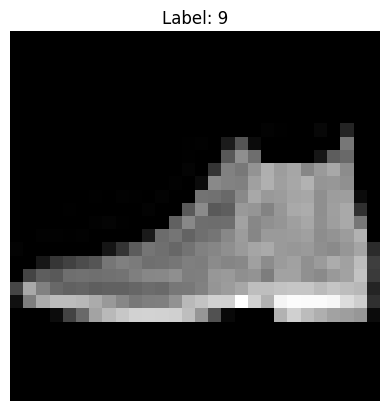

Image size: (28, 28)
Image class: 9
Total images in test dataset: 10000


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
import numpy as np

# # load data
raw_example_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

# Correct way to access dataset elements
# raw_example_data[index] returns a tuple (image, label)
image, label = raw_example_data[0]  # get the first element

# Convert image to numpy array for display
# FashionMNIST returns PIL Image, convert to numpy
image_array = np.array(image)

# Display image
plt.imshow(image_array, cmap='gray')  # use grayscale for FashionMNIST
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

# Alternative method using PIL
print("Method - using PIL Image directly:")
plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

# Data information
print(f"Image size: {image.size}")
print(f"Image class: {label}")
print(f"Total images in test dataset: {len(raw_example_data)}")

In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## Creating Models

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # Set model to training mode

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error (Forward Pass)
        pred = model(X) # Make prediction
        loss = loss_fn(pred, y) # Calculate error

        # Backpropagation
        loss.backward() # Compute new gradients
        optimizer.step() # Update model weights
        optimizer.zero_grad() # Clear old gradients

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Remind:
* Gradient - direction of the steepest ascent of a function
* Learning Rate - step size when updating weights
* Batch - small portion of data for training
* Epoch - one complete pass through all data

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # Total examples in test set
    num_batches = len(dataloader) # Number of batches
    model.eval() # set model to evaluation mode
    test_loss, correct = 0, 0 # accumulate total loss and correct predictions count
    with torch.no_grad(): # Key line: disable gradient computation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X) # Make prediction
            test_loss += loss_fn(pred, y).item() # Sum up loss
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # Count correct predictions

    # Calculate average values
    test_loss /= num_batches # Average loss per batch
    correct /= size # Accuracy percentage
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### 1. model.eval() - Evaluation Mode

What it does: Switches model to testing mode

Why it's needed:
- Disables Dropout layers (if present)
- Disables Batch Normalization (uses accumulated statistics)
- Indicates: "We're not training, only evaluating"

### 2. torch.no_grad() - No Gradients
What it does: Disables gradient computation and storage

Why it's needed:

- Memory saving - gradients take up significant memory
- Computation speedup - no need to calculate derivatives
- Prevention of accidental training - ensures model doesn't adapt to test data

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.288948  [   64/60000]
loss: 2.288833  [ 6464/60000]
loss: 2.266495  [12864/60000]
loss: 2.270983  [19264/60000]
loss: 2.259774  [25664/60000]
loss: 2.217296  [32064/60000]
loss: 2.230761  [38464/60000]
loss: 2.193706  [44864/60000]
loss: 2.193987  [51264/60000]
loss: 2.169078  [57664/60000]
Test Error: 
 Accuracy: 49.4%, Avg loss: 2.161151 

Epoch 2
-------------------------------
loss: 2.163795  [   64/60000]
loss: 2.162466  [ 6464/60000]
loss: 2.103508  [12864/60000]
loss: 2.124242  [19264/60000]
loss: 2.079996  [25664/60000]
loss: 2.012292  [32064/60000]
loss: 2.047878  [38464/60000]
loss: 1.966432  [44864/60000]
loss: 1.978828  [51264/60000]
loss: 1.910769  [57664/60000]
Test Error: 
 Accuracy: 59.3%, Avg loss: 1.900783 

Epoch 3
-------------------------------
loss: 1.933392  [   64/60000]
loss: 1.906665  [ 6464/60000]
loss: 1.786636  [12864/60000]
loss: 1.826468  [19264/60000]
loss: 1.726453  [25664/60000]
loss: 1.665271  [32064/600

# Saving Models

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models

In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


In [ ]:
classes[test_data[0][1]]

'Ankle boot'